# Introduction

This workbook will perform two optional post processing tasks. 

First, the background 

# Imports and mount drive

In [96]:
# Imports
%tensorflow_version 1.x
import numpy as np
from lucid.misc.io import show
from os.path import basename, join
from django.utils.text import get_valid_filename
from google.colab import drive
from PIL import Image
from scipy import ndimage as nd



In [97]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
root_dir = '/content/drive/My Drive/ra15808/Courses/Art_of_MD'

# Functions



In [99]:
def arr_to_img(arr):
    return Image.fromarray((arr*255).astype('uint8'))

def get_bg_col(img):
  """
  Background color is defined as the top left hand color
  """
  col = img[0, 0, :].reshape(3)
  return col

def create_alpha_mask(target, content, sigma=3, offset=0.2):
    """
    Creates a transparency layer. The minimium transparency 
    is `offset`, and it's completely transparent for those
    regions which are not the background color
    """
    black = np.array([0, 0, 0])
    white = np.array([1, 1, 1])
    bg_col = get_bg_col(content)
    # create a black/white mask based on background/non-background
    mask = np.all(content==bg_col, axis=-1)
    mask_img = content.copy()
    mask_img[mask] = white
    mask_img[~mask] = black
    # blur this mask with a Gaussian filter
    mask_img = nd.gaussian_filter(mask_img, sigma=sigma)
    # make a transparency layer
    alpha = np.clip(1-np.mean(mask_img, axis=-1) + offset, 0, 1)[:, :, np.newaxis]
    return alpha



# Load images

In [100]:
inp_dir = join(root_dir, 'images', 'target') # where the input images/arrays are
out_dir = join(root_dir, 'images', 'processed') # where to put the processed images

fname = 'InceptionV1__pymol_vis0001__okeefe__mixed3a__W100.00__mixed3a_mixed3b__W2.00__2.npy'
outname = fname.replace('.npy', '-processed.png')

vis_path = join(inp_dir, fname )
vis = np.load(vis_path)
target = vis[0, ...]
content = vis[1, ...]
style = vis[2, ...]



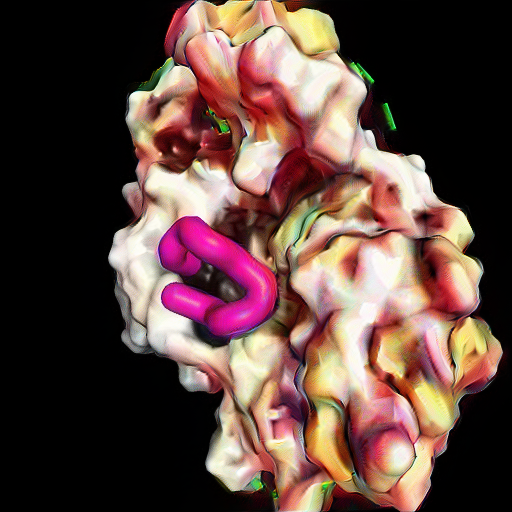

In [101]:
show(target)


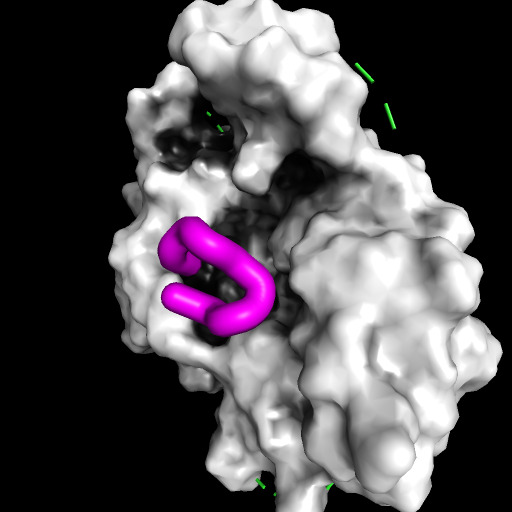

In [102]:
show(content)

# Background filter

I've created a function that creats an alpha channel based on the background color of the content image. 

* White is opaque (alpha = 1)
* Black is tranparent (alpha = 0)
* `offset` controls the the alpha value at the background
* `sigma` is the level of blurring (via a Gaussian blur) of the edge of the mask

(512, 512, 1)



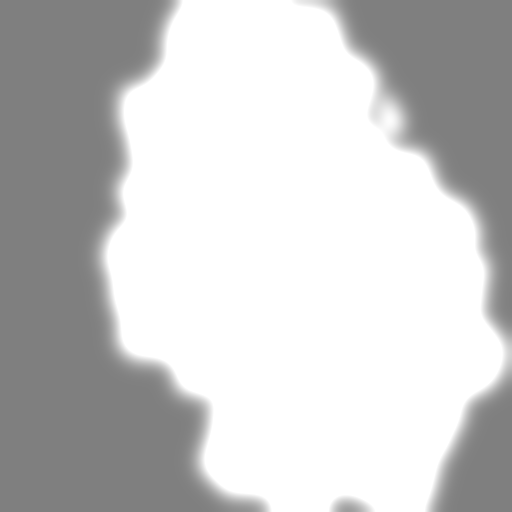

In [103]:
alpha = create_alpha_mask(target, content, sigma = 10, offset=0.5)
print(alpha.shape)
show(alpha)

Now you can add in your own background image (here I've added in the style image)


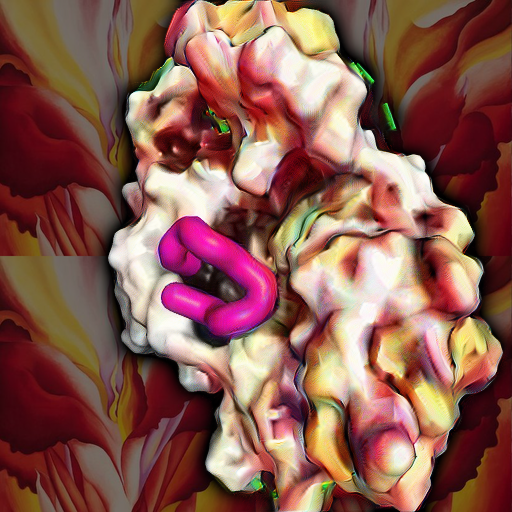

In [104]:
bg = style*(1-alpha)
fg = target*alpha
target_style_bg = bg+fg
show(target_style_bg)



Or just apply the alpha channel to the target (will make the original background more tranparent):


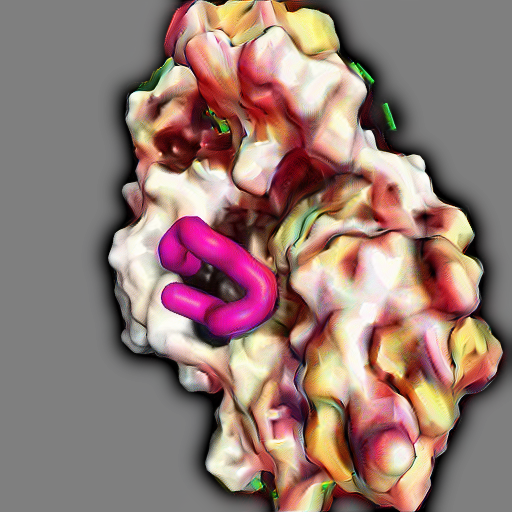

In [105]:
target_bg_alpha = np.concatenate([target, alpha], axis=-1)
show(target_bg_alpha)

# Save results

In [107]:
arr_to_img(target_style_bg).save(join(out_dir, outname))

In [108]:
join(out_dir, outname)

'/content/drive/My Drive/ra15808/Courses/Art_of_MD/images/processed/InceptionV1__pymol_vis0001__okeefe__mixed3a__W100.00__mixed3a_mixed3b__W2.00__2-processed.png'